# Spiral Attempt

In [14]:
import numpy as np
import matplotlib.pyplot as plt

from numpy.random import multivariate_normal as mvn

from scipy.stats import norm
from scipy.optimize import minimize

from math import floor
from math import log
from math import pi

from points import spiralPoints

from KNN import KNN

## Generate Points

Generate X values

In [115]:
m = 1002 # Number of samples (MAKE THIS A MULTIPLE OF 3)

knownvals = [int(j*m/3) for j in range(3)] # Points for which we know the value of the label

tranges = np.array([[0,pi/2], [3*pi,7*pi/2], [4*pi,9*pi/2]])
var = 3

X = spiralPoints(int(m/3), tranges[0,0], tranges[0,1], 4)
X = np.append(X, spiralPoints(int(m/3), tranges[1,0], tranges[1,1], 4), axis=0)
X = np.append(X, spiralPoints(int(m/3), tranges[2,0], tranges[2,1], 4), axis=0)

Generate Y values

In [116]:
y = [1 for i in range(int(m/3))]
y = y + [-1 for i in range(m - len(y))]

Plot points with labels

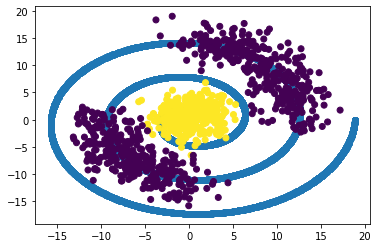

In [117]:
xs = X[:,0]
ys = X[:,1]

test = spiralPoints(10000,0,6*pi,0)
plt.scatter(test[:,0],test[:,1])

plt.scatter(xs, ys, c=y, cmap = "viridis")

## Build the Graph

In [132]:
k = 4
rbf = lambda x1, x2, gamma: np.exp(-gamma*np.linalg.norm(x1 - x2)**2)

L, W = KNN(X,k,m,rbf)

Making plot with edges

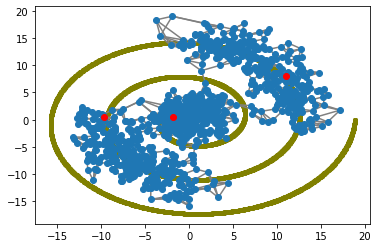

In [133]:
xs = X[:,0]
ys = X[:,1]

xs_k = [xs[j] for j in knownvals]
ys_k = [ys[j] for j in knownvals]

plt.scatter(xs, ys,zorder=1000)
plt.scatter(xs_k, ys_k, color="red",zorder=1000)

test = spiralPoints(10000,0,6*pi,0)
plt.scatter(test[:,0],test[:,1],zorder=0,color="olive",s=15)

for i in range(m):
	for j in range(i,m):
		if W[i,j] > 0:
			plt.plot([X[i,0],X[j,0]],[X[i,1],X[j,1]], color = "gray", zorder = 5)

## Form Optimization Problem

Define probit loss function

In [120]:
def probit(kvals, y, f):
	return -sum([log(norm.cdf(y[j]*f[j])) for j in kvals])

Define regression loss function

In [121]:
def regress(kvals, y, f):
	return sum([(y[j]-f[j])**2 for j in kvals])

Define regularization

In [122]:
def regular(lamb,C_inv,f):
    f_T = np.array(f).T
    return lamb*f_T.dot(C_inv).dot(f)

In [134]:
tau = 1
alpha: int = 2
lamb = (tau**(2*alpha))/2
C = np.linalg.matrix_power(((L + (tau**2)*np.eye(m))),-alpha)
C_inv = np.linalg.inv(C)

Going to minimization for Probit and regression

In [135]:
def to_minimize_pro(f,kvals,y,lamb,C_inv):
    return probit(kvals,y,f) + regular(lamb,C_inv,f)

In [136]:
def to_minimize_reg(f,kvals,y,lamb,C_inv):
    return regress(kvals,y,f) + regular(lamb,C_inv,f)

Results for probit

In [137]:
f0 = np.zeros(m)

result = minimize(to_minimize_pro, f0, args=(knownvals,y,lamb,C_inv), method='BFGS')

f_star = result.x

y_pred_probit = np.sign(f_star)

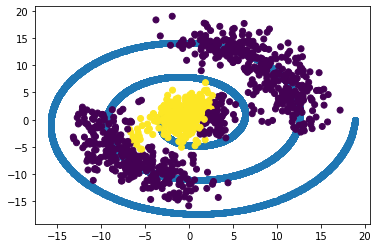

In [138]:
xs = X[:,0]
ys = X[:,1]

test = spiralPoints(10000,0,6*pi,0)
plt.scatter(test[:,0],test[:,1])

plt.scatter(xs, ys, c=y_pred_probit, cmap = "viridis")

Results for regression

In [139]:
f0 = np.zeros(m)

result = minimize(to_minimize_reg, f0, args=(knownvals,y,lamb,C_inv), method='BFGS')

f_star = result.x

y_pred_reg = np.sign(f_star)

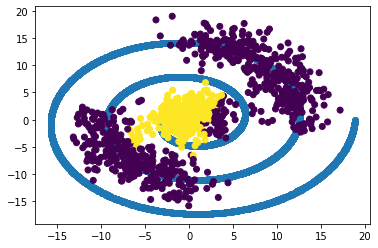

In [140]:
xs = X[:,0]
ys = X[:,1]

test = spiralPoints(10000,0,6*pi,0)
plt.scatter(test[:,0],test[:,1])

plt.scatter(xs, ys, c=y_pred_reg, cmap = "viridis")

Compute accuracy

In [141]:
accuracy_prob = sum([x[0] == x[1] for x in zip(y_pred_probit,y)])/m
print(accuracy_prob)

0.9101796407185628


In [142]:
accuracy_reg = sum([x[0] == x[1] for x in zip(y_pred_reg,y)])/m
print(accuracy_reg)

0.9291417165668663
